# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [21]:
import psycopg2
import pandas as pd

In [2]:
tables = {'hr_dataset':None,'production_staff':None,
         'recruiting_costs':None,
         'salary_grid':None}

In [7]:
pg_connection = {
    'host': 'dsstudents.skillbox.ru',
    'port': '5432',
    'dbname': 'human_resources',
    'user': 'readonly',
    'password': '6hajV34RTQfmxhS'
}

In [9]:
hr_data=pd.read_sql_query("SELECT * FROM hr_dataset ",conn)
prod_staff=pd.read_sql_query("SELECT * FROM production_staff ",conn)
recr_costs=pd.read_sql_query("SELECT * FROM recruiting_costs ",conn)
sal_grid=pd.read_sql_query("SELECT * FROM salary_grid ",conn)

In [10]:
print(hr_data[['maritalstatusid','maritaldesc']])


     maritalstatusid maritaldesc
0                  1     Married
1                  2    Divorced
2                  0      Single
3                  1     Married
4                  0      Single
..               ...         ...
305                0      Single
306                0      Single
307                0      Single
308                1     Married
309                1     Married

[310 rows x 2 columns]


Зависимость perfomance score и тем, под чьим руководством работает сотрудник

In [11]:
pd.read_sql('''SELECT DISTINCT "Performance Score" 
                FROM production_staff
                WHERE "Performance Score" is not Null''',conn)

,Performance Score
0,Exceptional
1,90-day meets
2,N/A- too early to review
3,Fully Meets
4,Exceeds
5,PIP
6,Needs Improvement


In [14]:
pd.read_sql('''SELECT DISTINCT "Manager Name", 
/*
Составим полную таблицу
*/
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceptional') as "Exceptional", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = '90-day meets') as "90-day meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'N/A- too early to review') as "N/A- too early to review", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Fully Meets') as "Fully Meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceeds') as "Exceeds", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'PIP') as "PIP", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Needs Improvement') as "Needs Improvement", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name") as "Sum"
                FROM production_staff A
                WHERE "Manager Name" is not Null''',
            conn)

,Manager Name,Exceptional,90-day meets,N/A- too early to review,Fully Meets,Exceeds,PIP,Needs Improvement,Sum
0,Amy Dunn,1,1,5,11,2,1,0,21
1,Brannon Miller,2,1,0,8,5,4,1,21
2,David Stanley,0,1,4,15,1,0,0,21
3,Elijiah Gray,0,3,3,14,2,0,1,23
4,Elisa Bramante,0,0,0,10,2,0,2,14
5,Kelley Spirea,0,3,1,15,3,0,0,22
6,Ketsia Liebig,0,2,2,14,2,0,1,21
7,Kissy Sullivan,1,3,1,14,1,1,1,22
8,Michael Albert,0,1,6,10,2,1,3,23
9,Webster Butler,0,3,3,11,2,0,2,21


У Brannon Miller больше всего сотрудников, качество работы которых превышает (Exceptional и Exceeds). У Michael Albert показатели сотрудников хуже всех (больше всех Needs Improvement, Fully Meets меньше всех, мало Exceeds и нет Exceptional). Отметим, что у него много сотрудников без оценок (N/A- too early to review).

Зависимость между продолжительностью работы в компании и семейным положением сотрудника

In [17]:
pd.read_sql(''' SELECT DISTINCT "maritaldesc" as Description,
/*
дальнейшие селекты работают по выбранному maritalstatusid (запрос с доп условием)
*/
                    (SELECT cast(avg(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Average", 
                    (SELECT cast(sum(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Sum", 
                    (SELECT count(B."Days Employed")
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Number of workers"
                FROM hr_dataset A
                WHERE "maritalstatusid" is not Null''',conn) 

,description,Average,Sum,Number of workers
0,Divorced,1103,33086,30
1,Married,1246,153287,123
2,Separated,1703,20441,12
3,Single,1373,188067,137
4,Widowed,863,6904,8


Зависимость между способом найма к количеству сотрудников и их суммарной зп.

In [18]:
third_task = pd.read_sql(''' SELECT A."Employment Source", A."Total",

                (SELECT count(hr_dataset."Employee Source") 
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Number of current workers",
                (SELECT CAST(A."Total" as int) / NULLIF(count(hr_dataset."Employee Source"), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Cost of one employee",
                (SELECT cast(sum(salary_grid."Salary Mid") as int) / NULLIF((SELECT count(hr_dataset."Employee Source")
                                                                                FROM recruiting_costs B
                                                                                JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                                                                                WHERE B."Employment Source"=A."Employment Source" and
                                                                                hr_dataset."Employment Status"='Active'), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    JOIN salary_grid on salary_grid."Position"=hr_dataset."position"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Average salary of one worker"
                FROM recruiting_costs A''',conn)
third_task

,Employment Source,Total,Number of current workers,Cost of one employee,Average salary of one worker
0,Billboard,6192,11,562.0,29818.0
1,Careerbuilder,7790,1,7790.0,48000.0
2,Company Intranet - Partner,0,0,NaN,NaN
3,Diversity Job Fair,10021,9,1113.0,30746.0
4,Employee Referral,0,24,0.0,45362.0
5,Glassdoor,0,7,0.0,44450.0
6,Information Session,0,2,0.0,33425.0
7,Internet Search,0,4,0.0,22856.0
8,MBTA ads,10980,12,915.0,34666.0
9,Monster.com,5760,13,443.0,24834.0


Самым эффективным методом найма был Employee Referral 
Самым дорогим способом оказался поиск Careerbuilder, дальше Social Networks - Facebook Twitter
Выгодным оказался Newspager/Magazine

<ipython-input-21-6326a6a76e69>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee',


<AxesSubplot:title={'center':'ЗП сотрудника к стоимости его найма'}, xlabel='Cost of one employee', ylabel='Average salary of one worker'>

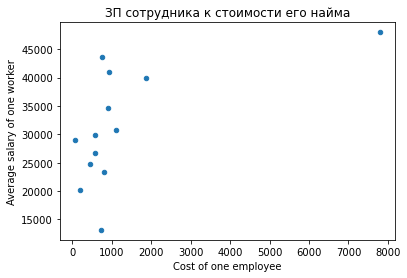

In [21]:
third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee', 
                                                   y='Average salary of one worker', 
                                                   kind='scatter',
                                                  title='ЗП сотрудника к стоимости его найма')

Идеальными способами поиска сотрудников будут те, чьи координаты в левом верхнем углу т.к. низкая стоимость за поиск одного сотрудника и высокая зп самого сотрудника (что говорит о его важности). 

## ЗАДАНИЕ 2


Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [3]:
import requests
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response
vk_token = 'a7afb78761840c38b0f6b87c4797265038cdd639b6f47129bf6dbf430bccff6e06b3073405d1ab6a1cf00'


In [4]:
from datetime import datetime, timedelta
k = -1
posts = list()
while True:
    k += 1
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + f'&owner_id=-66669811&offset={k}&count=1&v=5.92'
    response = getjson(url)
    try:
        it = response['response']["items"][0]
    except KeyError:
        k -= 1
        continue
    date = it['date']
    date = (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
    it['date'] = date
    if date >= '2021-06-23':
        print(f"Progress {date}")
        continue
    elif date < '2021-01-01':
        break
    else:
        posts.append(it)
    print(f"Progress {date}")

Progress 2021-11-01 13:32:31
Progress 2021-11-03 10:48:23
Progress 2021-11-02 18:44:40
Progress 2021-11-02 15:35:13
Progress 2021-11-01 16:22:41
Progress 2021-10-31 11:16:16
Progress 2021-10-30 15:26:38
Progress 2021-10-29 19:00:00
Progress 2021-10-29 17:28:21
Progress 2021-10-29 16:00:00
Progress 2021-10-29 10:36:28
Progress 2021-10-28 19:00:00
Progress 2021-10-28 18:58:23
Progress 2021-10-28 16:00:01
Progress 2021-10-28 12:34:00
Progress 2021-10-27 20:00:01
Progress 2021-10-27 17:00:02
Progress 2021-10-27 10:18:30
Progress 2021-10-26 17:06:17
Progress 2021-10-25 14:01:32
Progress 2021-10-25 12:47:54
Progress 2021-10-24 10:30:24
Progress 2021-10-23 13:23:50
Progress 2021-10-22 19:25:41
Progress 2021-10-22 18:36:03
Progress 2021-10-21 19:57:30
Progress 2021-10-21 14:02:20
Progress 2021-10-21 11:26:26
Progress 2021-10-20 19:04:02
Progress 2021-10-20 18:18:20
Progress 2021-10-20 15:17:35
Progress 2021-10-18 13:23:00
Progress 2021-10-17 12:36:34
Progress 2021-10-16 13:16:27
Progress 2021-

Progress 2021-06-15 17:35:12
Progress 2021-06-14 15:12:41
Progress 2021-06-14 12:20:49
Progress 2021-06-13 10:15:24
Progress 2021-06-12 15:32:31
Progress 2021-06-11 18:52:08
Progress 2021-06-11 16:45:49
Progress 2021-06-10 18:11:23
Progress 2021-06-10 14:32:22
Progress 2021-06-09 17:29:29
Progress 2021-06-09 15:25:51
Progress 2021-06-09 13:12:08
Progress 2021-06-08 19:24:46
Progress 2021-06-07 20:27:54
Progress 2021-06-07 18:41:53
Progress 2021-06-07 15:42:25
Progress 2021-06-07 13:08:19
Progress 2021-06-06 13:38:15
Progress 2021-06-05 13:41:36
Progress 2021-06-04 20:00:08
Progress 2021-06-04 12:27:54
Progress 2021-06-03 15:12:23
Progress 2021-06-03 11:08:35
Progress 2021-06-02 19:49:02
Progress 2021-06-01 18:52:10
Progress 2021-06-01 16:26:47
Progress 2021-05-31 17:41:23
Progress 2021-05-31 15:49:33
Progress 2021-05-31 14:02:13
Progress 2021-05-31 12:59:11
Progress 2021-05-30 11:00:51
Progress 2021-05-29 10:01:04
Progress 2021-05-28 17:50:00
Progress 2021-05-27 18:48:54
Progress 2021-

Progress 2021-01-19 18:54:54
Progress 2021-01-19 16:16:35
Progress 2021-01-18 18:25:50
Progress 2021-01-18 16:12:38
Progress 2021-01-18 13:04:32
Progress 2021-01-17 13:40:33
Progress 2021-01-16 13:51:10
Progress 2021-01-15 19:24:19
Progress 2021-01-15 19:00:26
Progress 2021-01-15 17:08:47
Progress 2021-01-15 15:36:57
Progress 2021-01-13 19:43:52
Progress 2021-01-13 17:11:47
Progress 2021-01-12 20:00:20
Progress 2021-01-12 18:04:23
Progress 2021-01-12 13:50:05
Progress 2021-01-11 19:25:55
Progress 2021-01-11 13:19:30
Progress 2021-01-10 14:04:25
Progress 2021-01-08 19:44:11
Progress 2021-01-08 17:00:18
Progress 2021-01-06 19:46:29
Progress 2021-01-04 17:00:23
Progress 2021-01-02 13:49:22


In [35]:
d_posts = {i:posts[i] for i in range(len(posts))}


In [36]:
import json
with open("posts.json", "w") as f:
    json.dump(d_posts, f)

In [37]:
posts = None
with open("posts.json",'r') as f:
    posts = json.load(f)

In [38]:
posts = list(posts.values())


In [9]:
posts[0]

{'id': 184068,
 'from_id': -66669811,
 'owner_id': -66669811,
 'date': '2021-06-22 18:19:33',
 'marked_as_ads': 0,
 'post_type': 'post',
 'text': 'В помощь геймдизайнеру:\n\n— Как придумать идею\n— Чем урбанистика поможет геймдизайнеру\n— Как сделать командную работу эффективной\n— Как создание игры помогает справиться с личной трагедией\n— В чём преимущества видеоигр перед реальной жизнью\n\nЧитайте нашу подборку, смотрите классные выступления!\n\n#skillbox_игры #статья_skillbox',
 'attachments': [{'type': 'link',
   'link': {'url': 'https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov',
    'title': '5 выступлений c TED, полезных для геймдизайнеров',
    'caption': 'm.vk.com',
    'description': 'Статья',
    'photo': {'album_id': -66,
     'date': 1624374957,
     'id': 457524151,
     'owner_id': -66669811,
     'has_tags': False,
     'sizes': [{'height': 45,
       'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.j

In [10]:
posts[0].keys()

dict_keys(['id', 'from_id', 'owner_id', 'date', 'marked_as_ads', 'post_type', 'text', 'attachments', 'post_source', 'comments', 'likes', 'reposts', 'views', 'is_favorite', 'hash'])

In [11]:
# Выделяем признаки
# Дата публикации
# Текст публикации
# Комментарии
# Лайки
# Репосты
# Просмотры
# тип поста

In [12]:
att_types = {}
for p in posts:
    for a in p['attachments']:
        if not a['type'] in att_types:
            att_types[a['type']] = a

In [13]:
att_types.keys()


dict_keys(['link', 'photo', 'video', 'poll', 'album', 'doc'])

In [14]:
for key, val in att_types.items():
    print('\n', key, '\n')
    for k, v in val[key].items():
        print(f'{k}:{v}')


 link 

url:https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov
title:5 выступлений c TED, полезных для геймдизайнеров
caption:m.vk.com
description:Статья
photo:{'album_id': -66, 'date': 1624374957, 'id': 457524151, 'owner_id': -66669811, 'has_tags': False, 'sizes': [{'height': 45, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=130x44&quality=96&sign=7cb1eb353ced6beb7e9017f830dc69dc&c_uniq_tag=mVPdM8O8Y938fxQ4ZjfEAplKQx0VL4IqQcHnVVMmJdw&type=album', 'type': 'm', 'width': 130}, {'height': 87, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=130x87&quality=96&crop=572,0,1195,800&sign=b46524ef63c2dbae277444049beef383&c_uniq_tag=Fmj6_IKdFI0o-VUm0BOgW-PcYJ4Jl6LYmcQ7xLZA7wU&type=album', 'type': 'o', 'width': 130}, {'height': 133, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=200x133&quality=96&crop=568,0,1203

In [15]:
import re # для хештегов
temp = re.compile(r"#[\wА-Яа-яЁё_]+")


In [16]:
df = dict.fromkeys(['id', 'date', 'time', 'text_len',
                    'attachments_num', 'hashtag','view',
                    'comment', 'like','repost',
                    'poll_votes', 'poll_answers'])
for i in df:
    df[i] = list()

In [17]:
posts[0]


{'id': 184068,
 'from_id': -66669811,
 'owner_id': -66669811,
 'date': '2021-06-22 18:19:33',
 'marked_as_ads': 0,
 'post_type': 'post',
 'text': 'В помощь геймдизайнеру:\n\n— Как придумать идею\n— Чем урбанистика поможет геймдизайнеру\n— Как сделать командную работу эффективной\n— Как создание игры помогает справиться с личной трагедией\n— В чём преимущества видеоигр перед реальной жизнью\n\nЧитайте нашу подборку, смотрите классные выступления!\n\n#skillbox_игры #статья_skillbox',
 'attachments': [{'type': 'link',
   'link': {'url': 'https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov',
    'title': '5 выступлений c TED, полезных для геймдизайнеров',
    'caption': 'm.vk.com',
    'description': 'Статья',
    'photo': {'album_id': -66,
     'date': 1624374957,
     'id': 457524151,
     'owner_id': -66669811,
     'has_tags': False,
     'sizes': [{'height': 45,
       'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.j

In [18]:
for i, el in enumerate(posts):
    id_ = i
    date, time = el["date"].split()
    text = el["text"]
    text_len = len(text)
    hashtags = temp.findall(text)
    view = el["views"]["count"]
    comment = el["comments"]["count"]
    like = el["likes"]["count"]
    repost = el["reposts"]["count"]
    attachments = el["attachments"]
    attachments_num = len(attachments)
    poll_votes = 0
    poll_answers = 0
    for a in attachments:
        if a["type"] == "poll":
            answers = a["poll"]["answers"]
            poll_answers = len(answers)
            for an in answers:
                poll_votes += an["votes"]
    for h in hashtags:
        df["id"].append(id_)
        df["date"].append(date)
        df["time"].append(time)
        df["text_len"].append(text_len)
        df["hashtag"].append(h[1:])
        df["view"].append(view)
        df["comment"].append(comment)
        df["like"].append(like)
        df["repost"].append(repost)
        df["attachments_num"].append(attachments_num)
        df["poll_votes"].append(poll_votes)
        df["poll_answers"].append(poll_answers)

In [19]:
df

{'id': [0,
  0,
  1,
  2,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  11,
  12,
  12,
  13,
  14,
  15,
  16,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  35,
  36,
  36,
  37,
  38,
  38,
  39,
  40,
  40,
  41,
  42,
  42,
  43,
  45,
  46,
  47,
  48,
  48,
  49,
  49,
  50,
  51,
  52,
  52,
  53,
  54,
  54,
  55,
  56,
  57,
  57,
  58,
  60,
  60,
  62,
  63,
  64,
  65,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  79,
  80,
  80,
  81,
  82,
  83,
  84,
  84,
  85,
  85,
  86,
  87,
  88,
  89,
  89,
  90,
  90,
  91,
  92,
  93,
  94,
  94,
  95,
  96,
  96,
  97,
  98,
  99,
  100,
  100,
  101,
  101,
  103,
  104,
  104,
  105,
  106,
  106,
  107,
  108,
  109,
  110,
  110,
  111,
  112,
  113,
  114,
  114,
  115,
  115,
  116,
  117,
  118,
  118,
  119,
  120,
  121,
  122,
  122,
  123,
  124,
  125,
  129,
  129,
  130,
  1

In [22]:
df = pd.DataFrame(df)
df.head()

,id,date,time,text_len,attachments_num,hashtag,view,comment,like,repost,poll_votes,poll_answers
0,0,2021-06-22,18:19:33,327,1,skillbox_игры,16580,0,50,52,0,0
1,0,2021-06-22,18:19:33,327,1,статья_skillbox,16580,0,50,52,0,0
2,1,2021-06-22,13:30:46,658,5,skillbox_курсы,16733,4,37,14,0,0
3,2,2021-06-21,18:43:52,110,1,skillbox_маркетинг,19409,6,52,49,0,0
4,2,2021-06-21,18:43:52,110,1,статья_skillbox,19409,6,52,49,0,0


In [23]:
del df_no_hash['index']
del df_no_hash['id']
df_no_hash.head()

NameError: name 'df_no_hash' is not defined

In [24]:
# смотрим матрицу корреляций

In [25]:
import seaborn as sns
corr_m = df.loc[:, 'text_len':].corr()
corr_m

,text_len,attachments_num,view,comment,like,repost,poll_votes,poll_answers
text_len,1.000000,0.061010,-0.015711,-0.013109,-0.073922,-0.121490,0.077854,0.098069
attachments_num,0.061010,1.000000,0.281799,0.054661,0.493241,0.363005,-0.050724,-0.060204
view,-0.015711,0.281799,1.000000,0.238094,0.527567,0.414487,0.160520,0.086288
comment,-0.013109,0.054661,0.238094,1.000000,0.177617,0.130933,0.316506,0.239960
like,-0.073922,0.493241,0.527567,0.177617,1.000000,0.768448,0.053446,-0.007823
repost,-0.121490,0.363005,0.414487,0.130933,0.768448,1.000000,-0.015497,-0.051557
poll_votes,0.077854,-0.050724,0.160520,0.316506,0.053446,-0.015497,1.000000,0.770408
poll_answers,0.098069,-0.060204,0.086288,0.239960,-0.007823,-0.051557,0.770408,1.000000


<AxesSubplot:>

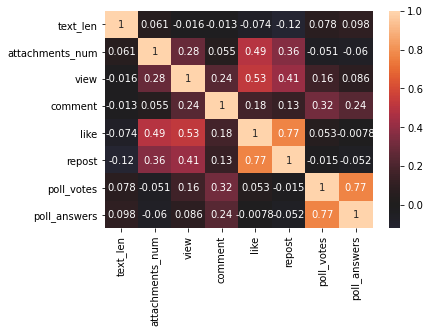

In [26]:
sns.heatmap(corr_m, center=0, annot=True)

* длина текста имеет слабо выраженную корреляцию
* доля просмотров хорошо выражена между лайками и репостами
* сильная положительная корелляция по долям лайков и репостов
* доля голосов пока не ясна.

<AxesSubplot:>

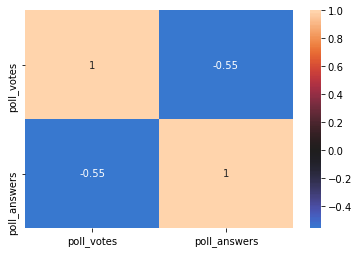

In [27]:
corr_m = df[df.poll_answers > 0].loc[:, 'poll_votes':].corr()
sns.heatmap(corr_m, center=0, annot=True)

In [28]:
df.head()

,id,date,time,text_len,attachments_num,hashtag,view,comment,like,repost,poll_votes,poll_answers
0,0,2021-06-22,18:19:33,327,1,skillbox_игры,16580,0,50,52,0,0
1,0,2021-06-22,18:19:33,327,1,статья_skillbox,16580,0,50,52,0,0
2,1,2021-06-22,13:30:46,658,5,skillbox_курсы,16733,4,37,14,0,0
3,2,2021-06-21,18:43:52,110,1,skillbox_маркетинг,19409,6,52,49,0,0
4,2,2021-06-21,18:43:52,110,1,статья_skillbox,19409,6,52,49,0,0


In [29]:
# чем больше вариантов ответов, тем меньше проголосовавщих

In [30]:
count = df.groupby("hashtag").count().loc[:, "id":"id"]
count

,id
hashtag,
BKMenuCourt,1
Ruarts_Skillbox,1
Ruartsfoundation,1
Skillbox,4
Skillbox_Clubhouse,1
...,...
лекторий_skillbox,12
работа_студента_skillbox,4
совет_препода_skillbox,1


In [31]:
count[count["id"] > 4]
# отсортируем

,id
hashtag,
Skillbox_Дизайн,5
Skillbox_вдохновляет,5
Skillbox_дизайн,23
skillbox,6
skillbox_анонс,20
skillbox_вдохновляет,5
skillbox_дизайн,41
skillbox_игры,5
skillbox_маркетинг,45


In [32]:
# 13 рубрик
rubrics = list(count[count["id"] > 4].index)
rubrics


['Skillbox_Дизайн',
 'Skillbox_вдохновляет',
 'Skillbox_дизайн',
 'skillbox',
 'skillbox_анонс',
 'skillbox_вдохновляет',
 'skillbox_дизайн',
 'skillbox_игры',
 'skillbox_маркетинг',
 'skillbox_программирование',
 'skillbox_управление',
 'В_Закладки_Skillbox',
 'В_закладки_Skillbox',
 'Высшее_образование_Skillbox',
 'Лекторий_Skillbox',
 'Расписание_Skillbox',
 'Статья_Skillbox',
 'Статья_skillbox',
 'в_закладки_skillbox',
 'высшее_образование_skillbox',
 'лекторий_skillbox',
 'статья_skillbox']

In [33]:
import numpy as np
def av_med(df):
    cols = ["comment", "like", "repost"]
    meds = []
    if df.shape[0] != df[df["poll_votes"] == 0].shape[0]:
        meds.append(df[df["poll_votes"] != 0]["poll_votes"].median())
    for i in cols:
        meds.append(df[i].mean())
    return np.mean(meds)

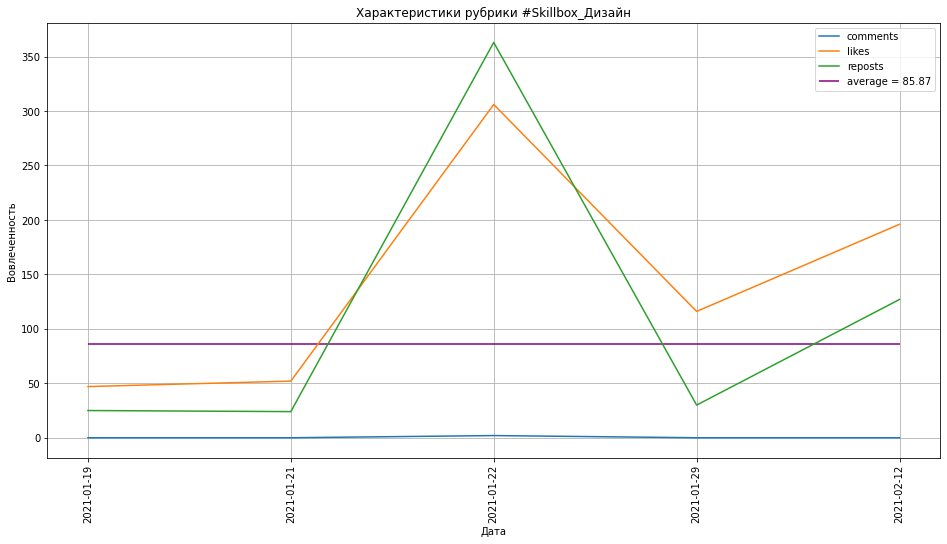

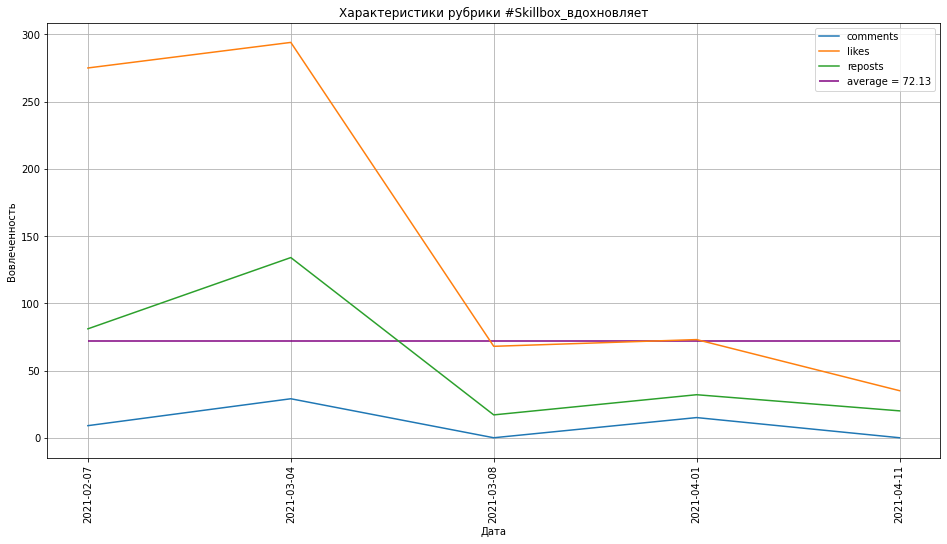

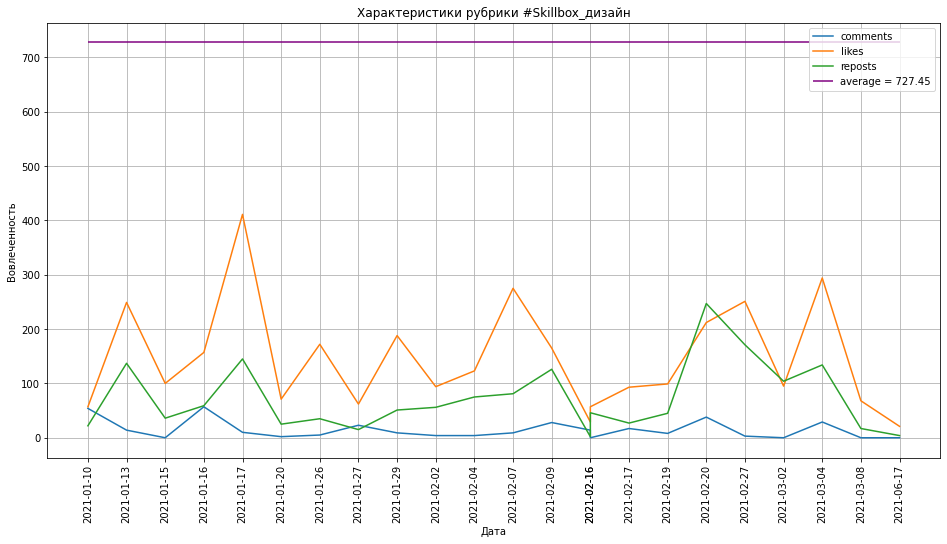

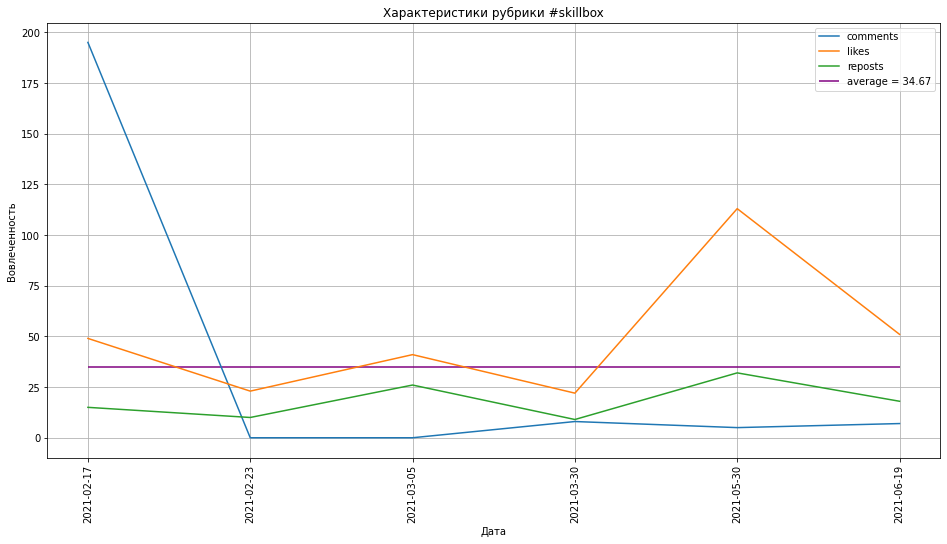

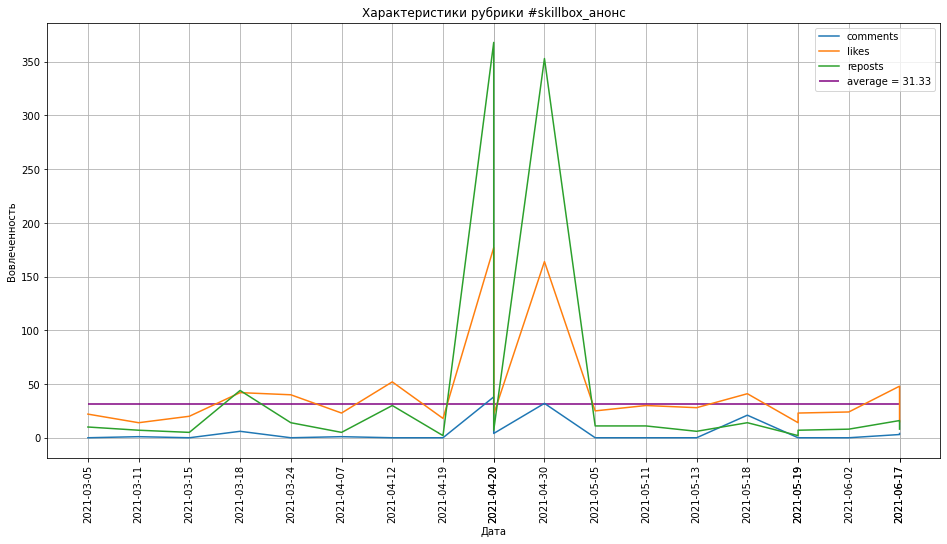

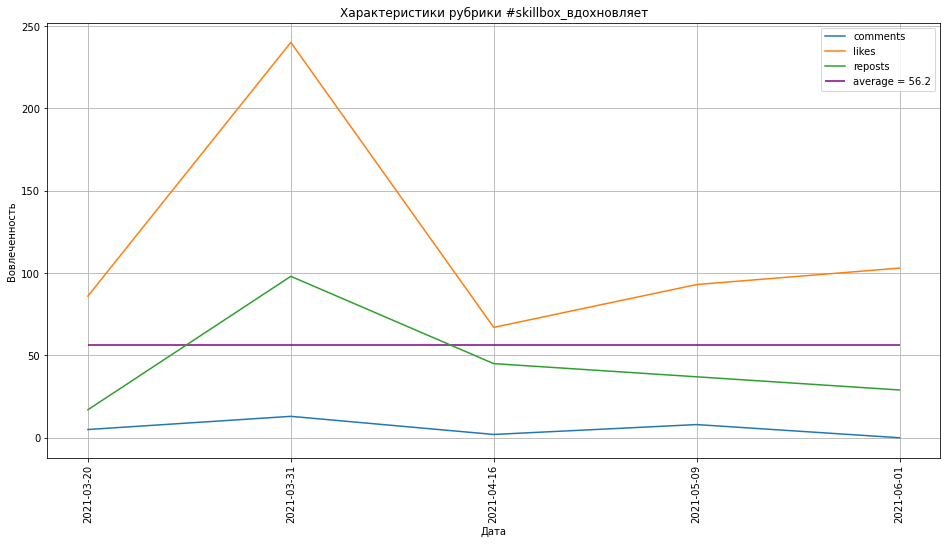

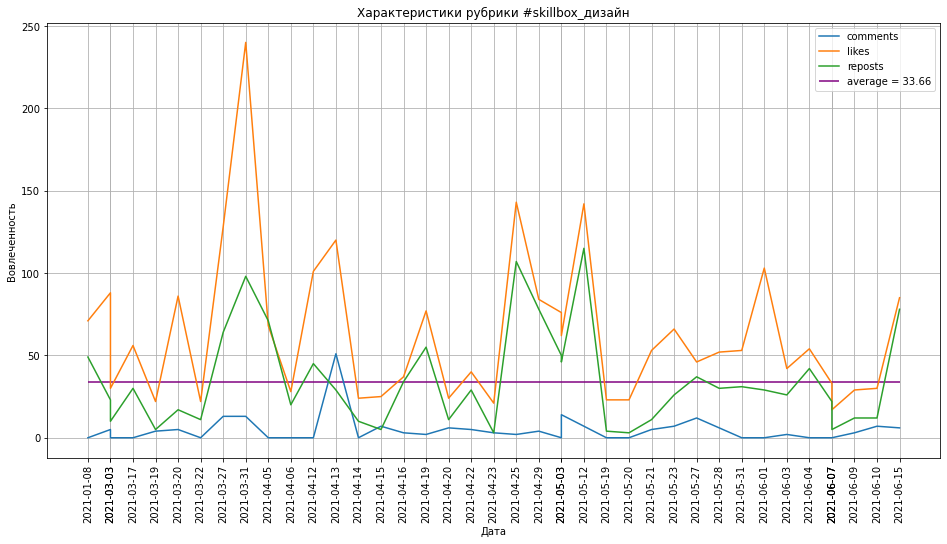

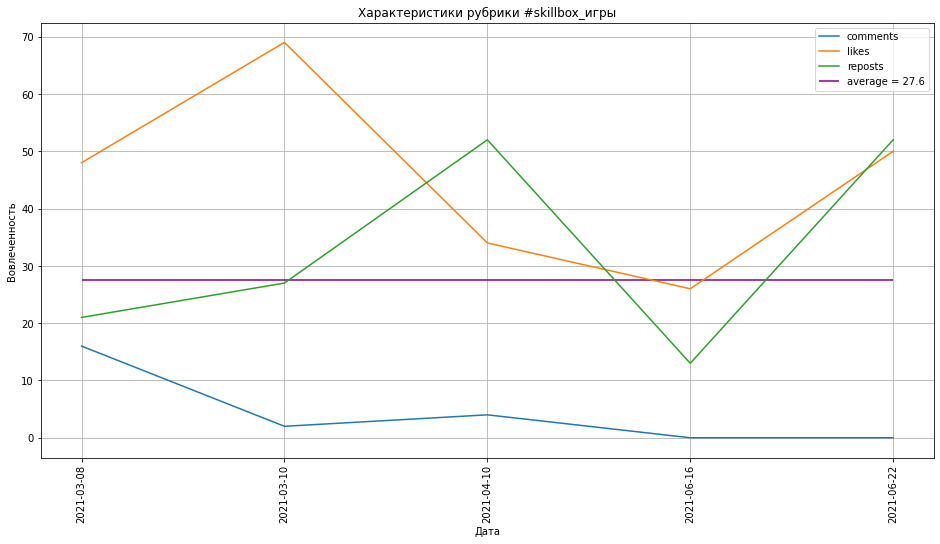

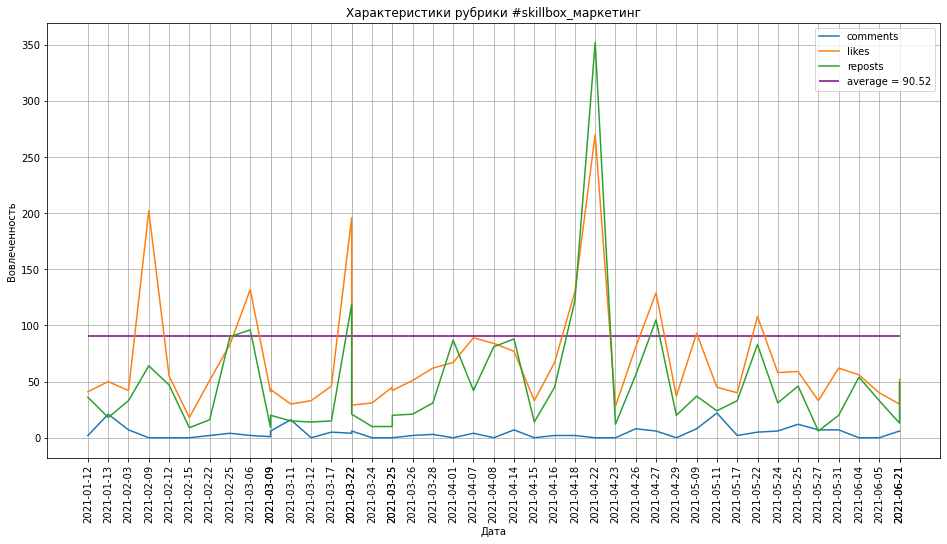

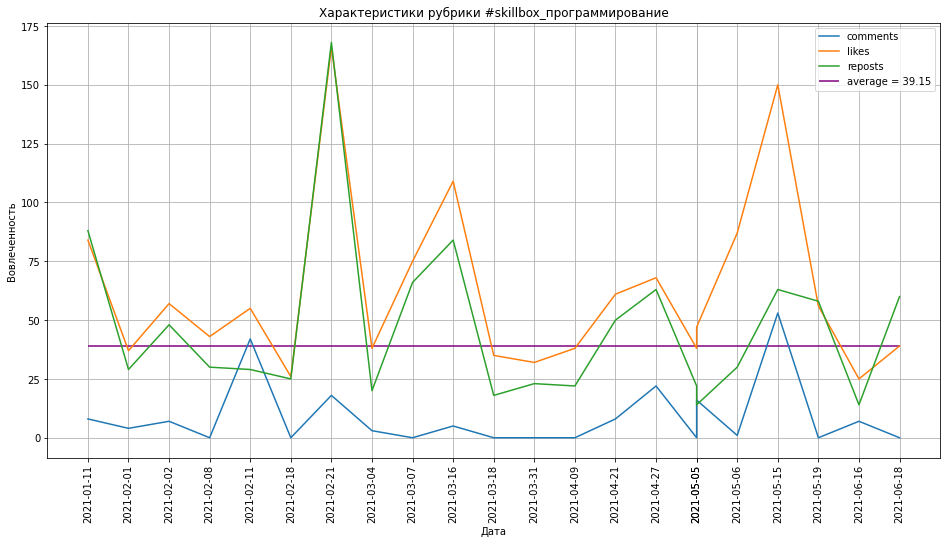

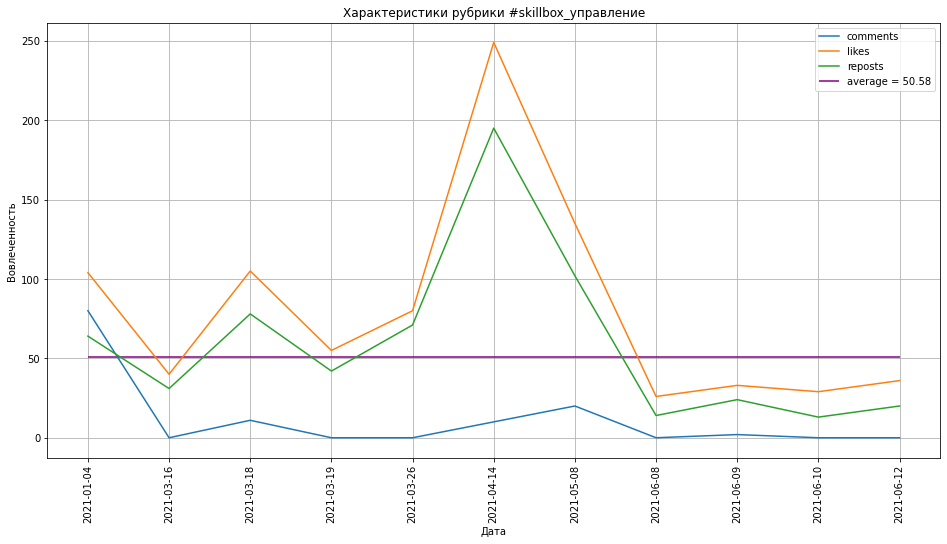

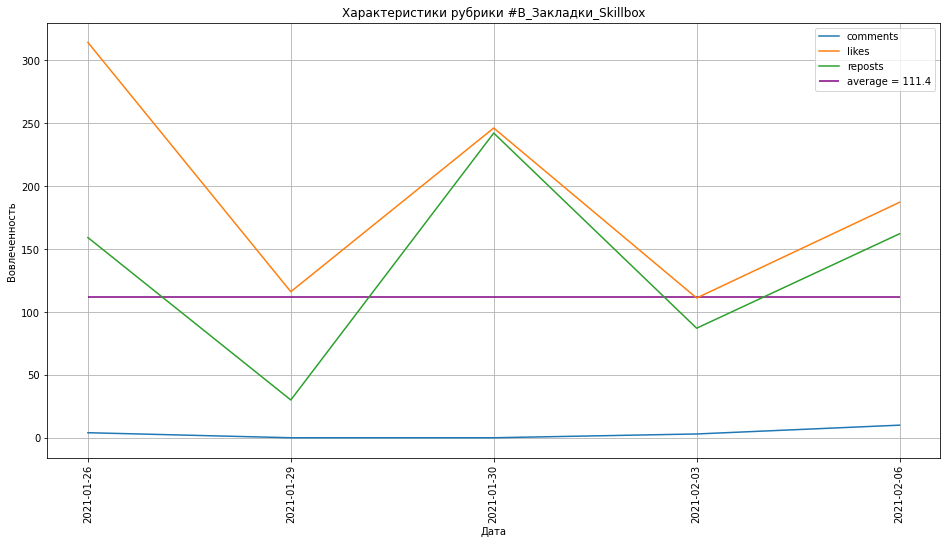

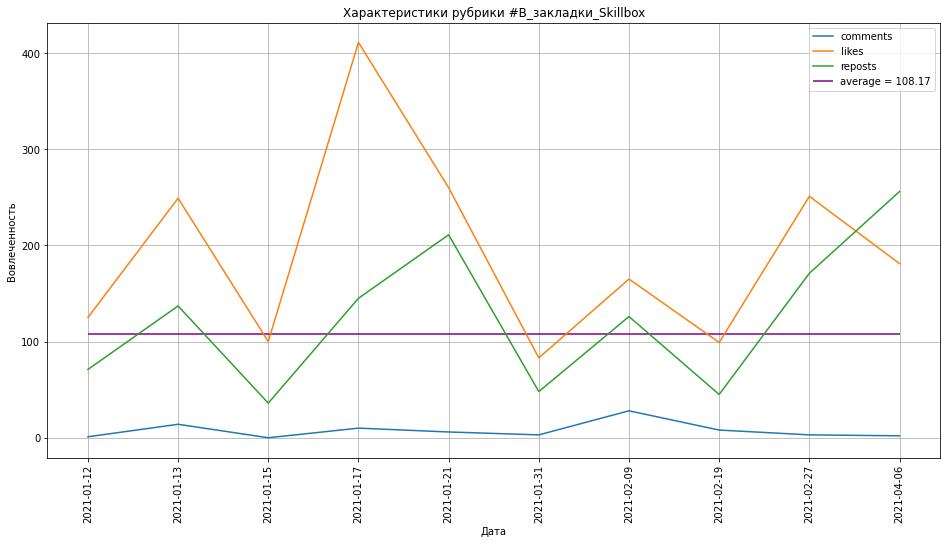

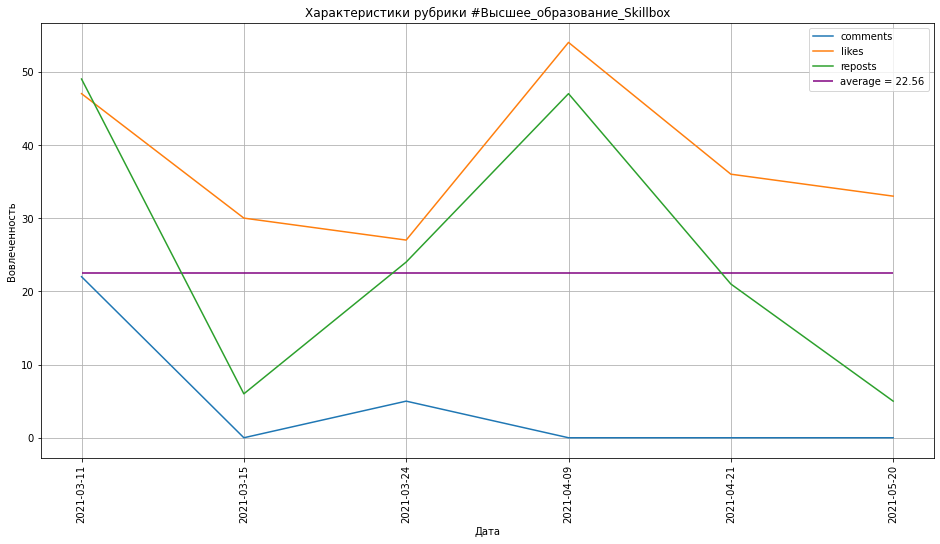

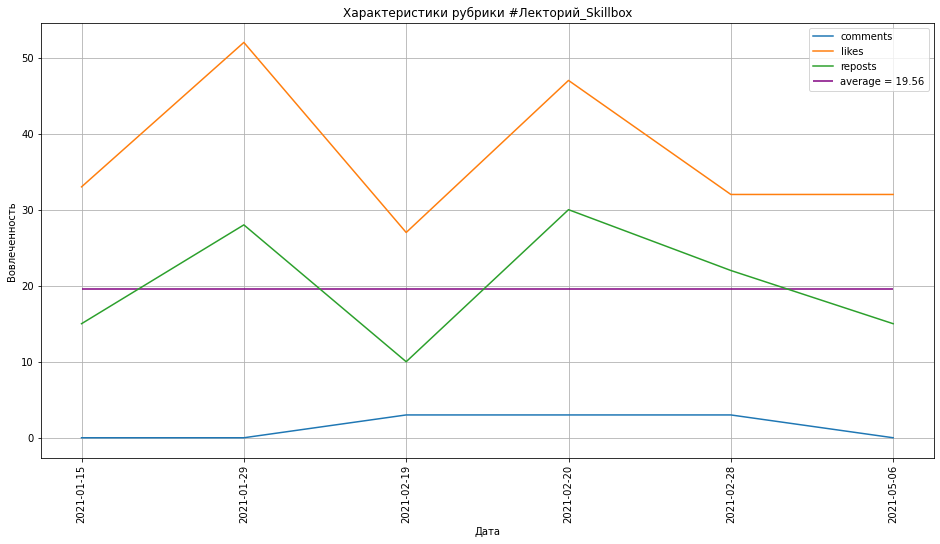

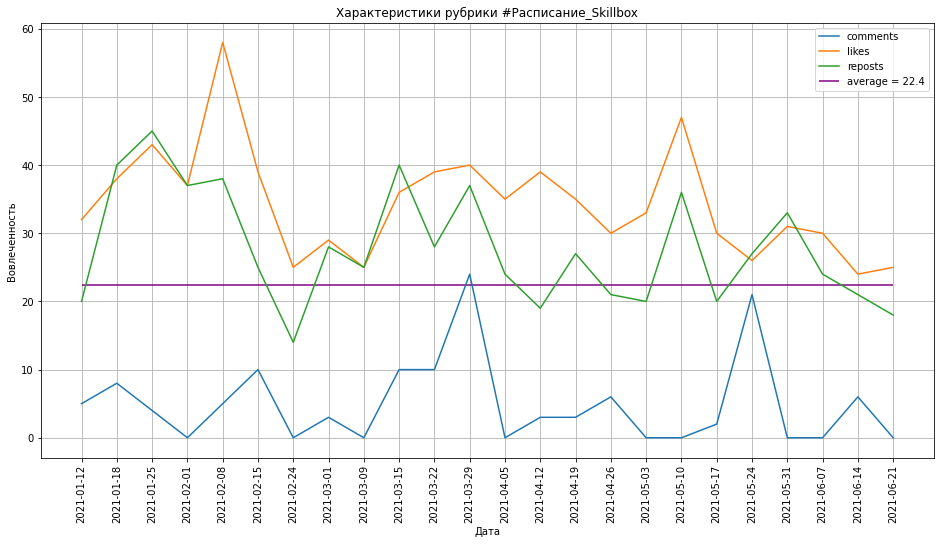

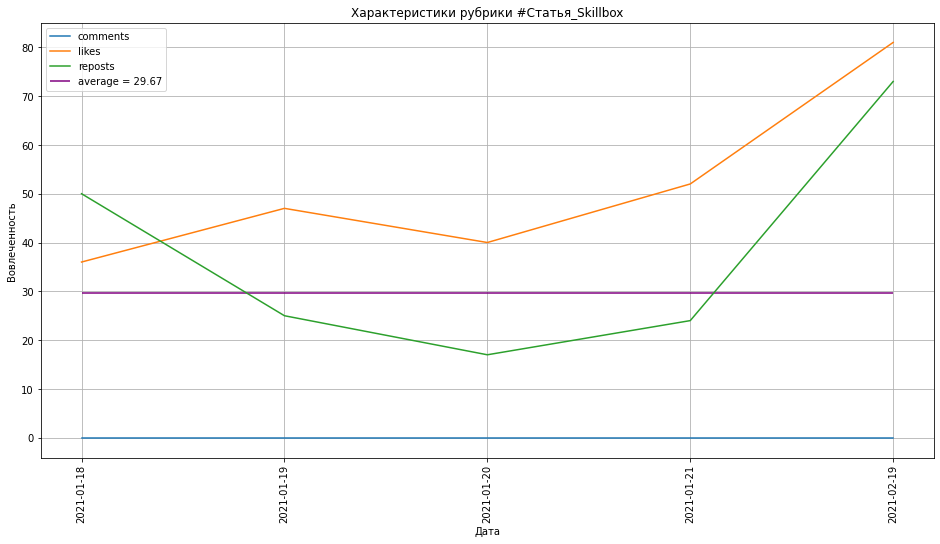

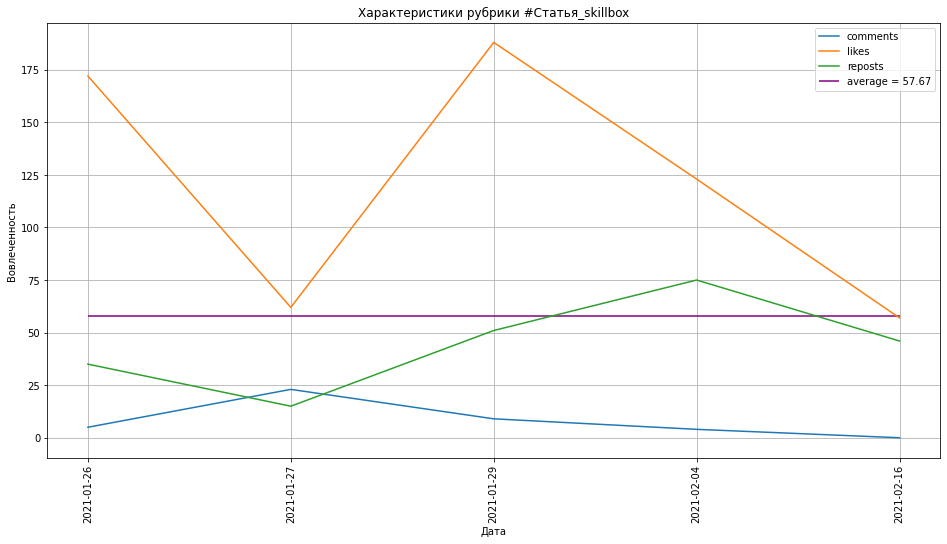

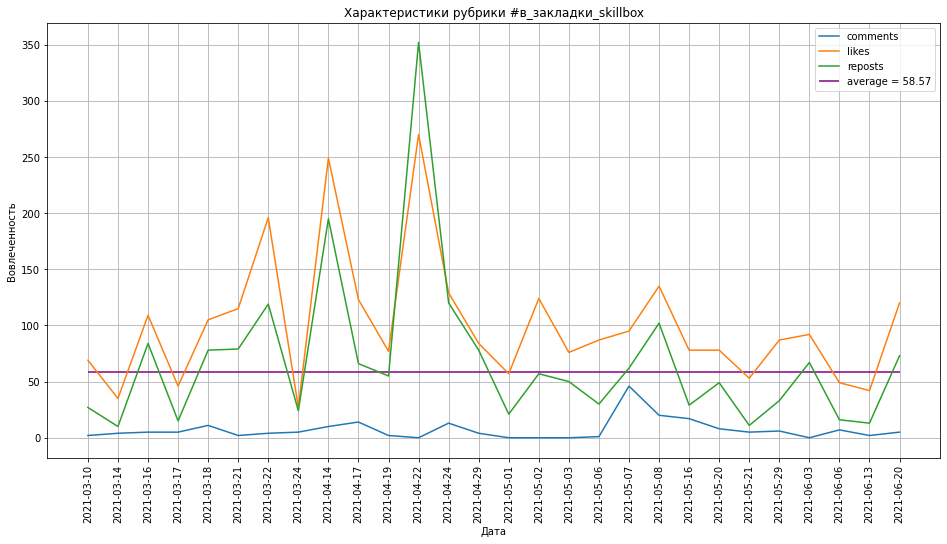

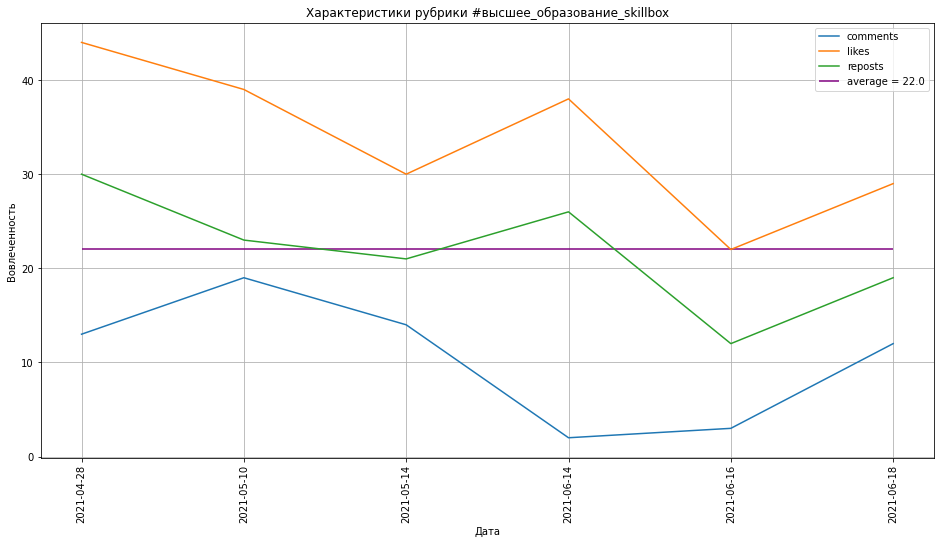

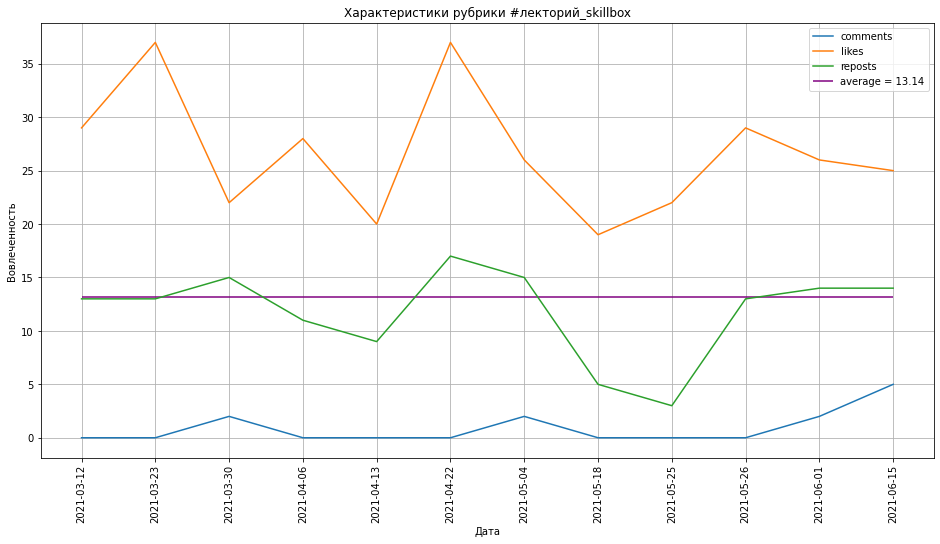

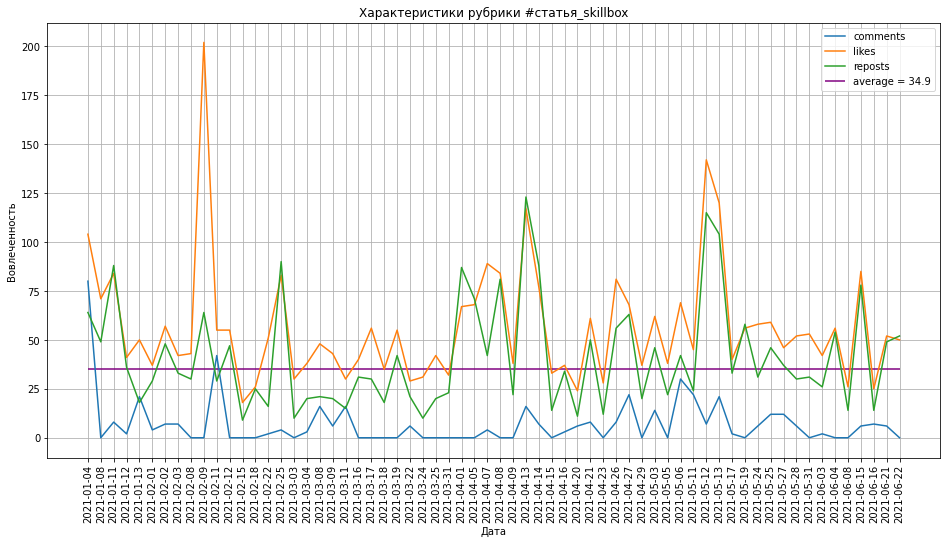

In [34]:
from matplotlib import pyplot as plt
df = df.sort_values("date")
for ind, r in enumerate(rubrics):
    current_df = df[df["hashtag"] == r]
    xticks = current_df["date"]
    am = av_med(current_df)
    fig, subplot = plt.subplots()
    fig.set_size_inches(16, 8)
    plt.plot(xticks, current_df["comment"], label = "comments")
    plt.plot(xticks, current_df["like"], label = "likes")
    plt.plot(xticks, current_df["repost"], label = "reposts")
    plt.hlines(am, list(xticks)[0], list(xticks)[-1], color = "purple", label = f"average = {round(am, 2)}")
    plt.xticks(xticks, rotation = "vertical")
    plt.xlabel("Дата")
    plt.ylabel("Вовлеченность")
    plt.legend()
    plt.grid()
    plt.title(f"Характеристики рубрики #{r}")
    plt.show()